In [0]:

from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import random
import numpy as np
import pandas as pd
import keras
from sklearn.model_selection import train_test_split
from keras.layers import Conv2D, Conv3D, MaxPooling2D, MaxPooling3D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense, Activation
from keras.layers import Input, Dense
from keras.models import Model
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from keras.utils import plot_model
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator



Using TensorFlow backend.


In [0]:
train_data =  pd.read_json('/content/drive/My Drive/kaggle/data/train/train.json')
test_data =   pd.read_json('/content/drive/My Drive/kaggle/data/test/test.json')

In [0]:
train_data[ 'inc_angle' ] = train_data[ 'inc_angle' ].replace('na', 0)
train_data[ 'inc_angle' ] = train_data[ 'inc_angle' ].astype(float).fillna(0.0)

In [0]:
def get_images(df):
    imgs = []
    
    for i, row in df.iterrows():
        band_1 = np.array(row['band_1']).reshape(75, 75)
        band_2 = np.array(row['band_2']).reshape(75, 75)
        
        # Rescale
        im1 = (band_1 - band_1.mean()) / (band_1.max() - band_1.min())
        im2 = (band_2 - band_2.mean()) / (band_2.max() - band_2.min())
        imgs.append(np.dstack((im1, im2)))

    return np.array(imgs)

train_images = get_images(train_data)
train_labels = train_data['is_iceberg'].values
train_angles = train_data['inc_angle'].values
test_images = get_images(test_data)
test_angles = test_data['inc_angle'].values

X_train, X_valid, ang_train, ang_valid, y_train_lab, y_valid_lab = train_test_split(train_images, train_angles, train_labels, test_size = 0.25, random_state = 42)

y_train_ang_lab = np.array([ np.array([a, y]) for (a, y) in zip(ang_train, y_train_lab)])
y_valid_ang_lab = np.array([ np.array([a, y]) for (a, y) in zip(ang_valid, y_valid_lab)])

In [0]:
def cnnModel(with_summary = True):
    inputs = Input(shape=(75, 75, 3), name='image_input')
    x = Conv2D(64, (3, 3), activation='relu')(inputs)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.1)(x)

    x = Conv2D(128, (3, 3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.1)(x)

    x = Conv2D(128, (3, 3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Flatten()(x)
    x = Dropout(0.7)(x)

    auxiliary_input = Input(shape=(1,), name='angle_input')
    x = keras.layers.concatenate([x, auxiliary_input])

    x = Dense(256, activation='relu')(x)
    x = Dropout(0.7)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.7)(x)
    predictions = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=[inputs, auxiliary_input], outputs=predictions)
    
    if with_summary:
        model.summary()
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = cnnModel()






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_input (InputLayer)        (None, 75, 75, 2)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 73, 73, 64)   1216        image_input[0][0]                
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 36, 36, 64)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 36, 36, 64)   0           max_po

In [0]:
for i,layer in enumerate(model.layers):
    print(i,layer.name)
print("\nTotal number of layers in the model are:  "+str(len(model.layers)-1))

0 image_input
1 conv2d_1
2 max_pooling2d_1
3 dropout_1
4 conv2d_2
5 max_pooling2d_2
6 dropout_2
7 conv2d_3
8 max_pooling2d_3
9 flatten_1
10 dropout_3
11 angle_input
12 concatenate_1
13 dense_1
14 dropout_4
15 dense_2
16 dropout_5
17 dense_3

Total number of layers in the model are:  17


In [0]:
from keras.preprocessing.image import ImageDataGenerator

def generate_data_generator_for_two_sources(datagen, images, y, batch_size):
    flow = datagen.flow(images, y, seed=7, batch_size=batch_size)

    while True:
            f = flow.next()
            yield [f[0], f[1][:, 0]], f[1][:, 1]

In [0]:
def get_callbacks( no_improv_epochs = 10, min_delta = 1e-4 ):
    
    
    es = EarlyStopping( 'val_loss', patience = no_improv_epochs, 
                        mode = 'min', min_delta = min_delta )
    
    return [ es ]
EARLY_STOPPING = 7
callback_list = get_callbacks(EARLY_STOPPING)

In [0]:

epochs = 200
batch_size = 32

train_datagen = ImageDataGenerator(
        rotation_range=360,
        width_shift_range=0.6,
        height_shift_range=0.6,
        shear_range=0.1,
        zoom_range=0.4,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='wrap')

valid_datagen = ImageDataGenerator()


earlyStopping = EarlyStopping(monitor='val_loss', patience=30, verbose=0, mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=15, verbose=1, epsilon=1e-4, mode='min')
#checkpointer = ModelCheckpoint(filepath='/content/drive/My Drive/kaggle/aug_model.weights.best.hdf5', 
                             #  verbose=1, save_best_only=True)

history = model.fit_generator(generate_data_generator_for_two_sources(train_datagen, X_train, y_train_ang_lab, batch_size=batch_size),
                    steps_per_epoch=X_train.shape[0] // batch_size,
                    epochs=20, verbose=1, callbacks=callback_list,
                    validation_data=generate_data_generator_for_two_sources(valid_datagen, X_valid, y_valid_ang_lab, batch_size=batch_size),
                    validation_steps=X_valid.shape[0] // batch_size)

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:1335: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '





Epoch 1/15




/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/numpy_array_iterator.py:127: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (401, 75, 75, 2) (2 channels).
  str(self.x.shape[channels_axis]) + ' channels).')
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/numpy_array_iterator.py:127: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1203, 75, 75, 2) (2 channels).
  str(self.x.shape[channels_axis]) + ' channels).')





37/37 [==============================] - 30s 817ms/step - loss: 0.8435 - acc: 0.5312 - val_loss: 0.6491 - val_acc: 0.5052
Epoch 2/15
37/37 [==============================] - 28s 770ms/step - loss: 0.7291 - acc: 0.5463 - val_loss: 0.6288 - val_acc: 0.7290
Epoch 3/15
37/37 [==============================] - 28s 765ms/step - loss: 0.6912 - acc: 0.5486 - val_loss: 0.6490 - val_acc: 0.4878
Epoch 4/15
37/37 [==============================] - 28s 765ms/step - loss: 0.7037 - acc: 0.5376 - val_loss: 0.6180 - val_acc: 0.5637
Epoch 5/15
37/37 [==============================] - 29s 780ms/step - loss: 0.6499 - acc: 0.5990 - val_loss: 0.6055 - val_acc: 0.6911
Epoch 6/15
37/37 [==============================] - 29s 787ms/step - loss: 0.6293 - acc: 0.6418 - val_loss: 0.5997 - val_acc: 0.6965
Epoch 7/15
37/37 [==============================] - 29s 788ms/step - loss: 0.5960 - acc: 0.6694 - val_loss: 0.6119 - val_acc: 0.6206
Epoch 8/15
37/37 [==============================] - 28s 763ms/step - loss: 0.

In [0]:
predictions = model.predict([test_images, test_angles])

y_pred = np.argmax(predictions, axis=1)

In [0]:

def plot_history(history):
    # history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()

    # history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
def plot_confusion_matrix(y_test, y_pred):
    cnf_matrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(cnf_matrix, square=True, cmap='RdYlGn')
    plt.show()

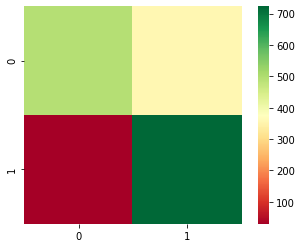

In [0]:
pred_val = model.predict([train_images, train_angles])
pred_val = pred_val.reshape((pred_val.shape[0]))
plot_confusion_matrix(train_labels, pred_val )

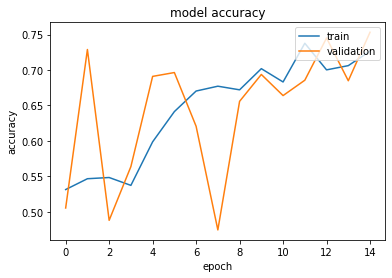

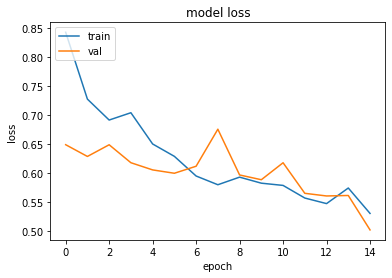

In [0]:
plot_history(history)

In [0]:
val_score = model.evaluate( [X_valid, ang_valid], y_valid_lab, verbose = 1 )
print( 'Validation score: {:.3f}'.format(val_score[0]) )
print( 'Validation accuracy: {:.2f}%'.format(val_score[1]*100) )
print( '='*20, '\n' )

401/401 [==============================] - 2s 6ms/step
Validation score: 0.514
Validation accuracy: 75.31%



In [0]:
train_score = model.evaluate( [X_train, ang_train], y_train_lab, verbose = 1 )
print( 'Train score: {:.3f}'.format(train_score[0]) )
print( 'Train accuracy: {:.2f}%'.format(train_score[1]*100) )
print( '='*20, '\n' )

1203/1203 [==============================] - 7s 6ms/step
Train score: 0.492
Train accuracy: 75.98%



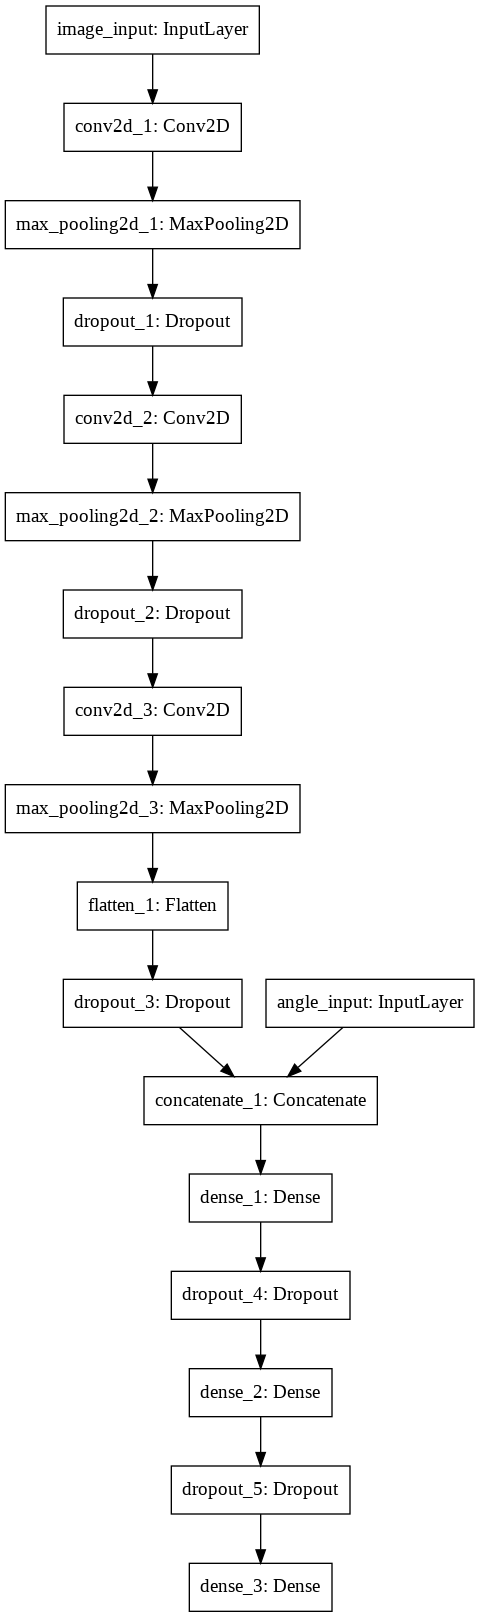

In [0]:
plot_model(model)

In [0]:
from sklearn.metrics import classification_report
print(classification_report(train_labels, pred_val > 0.5))

              precision    recall  f1-score   support

           0       0.94      0.58      0.72       851
           1       0.67      0.96      0.79       753

    accuracy                           0.76      1604
   macro avg       0.81      0.77      0.75      1604
weighted avg       0.81      0.76      0.75      1604



In [0]:
confusion_matrix(train_labels, pred_val )

array([[493, 358],
       [ 30, 723]])

In [0]:
from sklearn.metrics import precision_recall_fscore_support